# <ins>Text Data Mining Notebook for Frank Arnott</ins>
***

<img src="messy_desk.jpg"
     alt="Messy Desk"
     style="float: left; margin-right: 10px;"
     width="500px"/>

<center><i>Photo by <a href="https://unsplash.com/@sametkurtkus?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Samet Kurtkus</a> on <a href="https://unsplash.com/s/photos/messy-desk?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a></i><br>
Where did I put that paper???</center>

In [1]:
# Import the libraries that will be used in this notebook
import pandas as pd
import string
import missingno as msno
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from nltk.stem import PorterStemmer
from ast import literal_eval
%matplotlib inline
pd.set_option('display.max_colwidth', None)

## *Overview*
---
Note: This notebook will use the BCGS Lithogeochem database as a "proof of concept". A csv of that database has been included.

Our ability to collect and store data over the past 20 years has far surpassed our abilities to analyze it.
Data that appears to have no value or is too difficult to parse because of their unstructured nature get stored and ignored.  

We aim to develop some starter tools using Python, and open source software, that help geologists add value to their databases and demonstrate these tools on the Quesnel area. Some of these tools have been integrated in our other approaches on this project. These tools should be abstract in nature (apply to many situations), and simple to use (not require expert coding abilities).

Data mining itself is a misnomer. Just as we don’t “rock mine”, we don’t intend to “data mine”. Our goal is to get value from the data as one would get gold from a deposit.
KDD (Knowledge Discovery in Databases), better describes our purpose with these tools. We want to extract information, from the data.

### *Methodology*
* Import the Excel file into the notebook.
* Perform some simple exploratory data analysis, and do some data cleaning and maintenance with the purpose of creating a column for text data mining.
* Create terminology feature columns as "sets of words".
* Add inference rules to include words that are not contained in the database but use domain knowledge.
* Import these results into a geodatabase, GIS software, geoPandas, or however the geologist requires for their use-case scenario.


### *Utility methods*

These are utility methods you can feel free to use as you see fit during your data cleaning, and fine tuning of the raw dataset.

In [2]:
def test_word(word1, word2):
    '''
    Takes two words and returns the fuzzy ratio between the stemmed words. This is a percentage similarity between
    these two words after stemming. It can be used to check for cutoff values.
    
    E.g. print(test_word('porphyry', 'porphyritic'))
         - 88
    '''
    porter = PorterStemmer()
    word1 = porter.stem(word1)
    word2 = porter.stem(word2)
    return fuzz.ratio(word1, word2)

In [3]:
def get_term_list(df, col):
    term_list = df[col].tolist()
    term_list = [x for x in term_list if str(x) != 'nan']
    return term_list

In [4]:
def get_names(row, word_list, column, thresh=85):
    string1 = row[column]
    matches = []
    porter = PorterStemmer()
    for name1 in string1.split():
        name1 = porter.stem(name1)
        for name2 in word_list:
            comparison_word = porter.stem(name2)
            ratio = fuzz.ratio(name1, comparison_word)
            if ((ratio > thresh) and (name2 not in matches)):
                matches.append(name2)
    return matches

## *Import file into Notebook and basic EDA*
---

In [5]:
input_file = 'C:/input/geochem_raw.xlsx'
config_file = 'C:/input/config.xlsx'
df = pd.read_excel(input_file)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11635 entries, 0 to 11634
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sample_code  11635 non-null  object 
 1   wgs84_lat    11635 non-null  float64
 2   wgs84_long   11635 non-null  float64
 3   lithology    11633 non-null  object 
 4   sample_desc  11634 non-null  object 
dtypes: float64(2), object(3)
memory usage: 454.6+ KB


In [7]:
df.head()

,sample_code,wgs84_lat,wgs84_long,lithology,sample_desc
0,85GMC-RM001,51.187788,-123.646687,None,"bleached, sericitic shear zone; quartz veined; 3% pyrite, cuts andesitic volcanic"
1,85GMC-RM002,51.258482,-123.777376,None,Quartz-carbonate alteration zone adjacent to felsite intrusive; 2-5% pyrite
2,85GMC-RM003,51.196667,-123.666848,None,"carbonate veinlets carrying malachite, bornite, chalcopyrite cutting andesite"
3,85GMC-RM004,51.189498,-123.662452,None,strongly bleached and pyritic shear zone cutting andesites
4,85GMC-RM005,51.140817,-123.823286,None,dacite; weakly silicifed; pyrite and pyrrhotite


In [8]:
df.nunique()

sample_code    11635
wgs84_lat       8950
wgs84_long      8946
lithology       1418
sample_desc     4325
dtype: int64

A quick look at our dataset shows that we have a sample_id column, spatial information, and two columns which appear to contain text data.  Our "null" values are labelled as "None", which will need to be dealt with. Our text data contains a mix of capitals, punctuations, as well as most likely abbreviations and spelling errors.

Out of 11635 total rows, we have 11635 unique sample_code enteries. This is good as it shows our sample_code is a unique identifier. We also see a large amount of unique entries for our 2 text columns, meaning there is likely no standard that was used for those columns.

## *Data cleaning and preperation*

First thing we should do is replace the "None" values with proper NaN values, so we can see how much of the dataset is missing information.


In [9]:
df = df.replace("None",  np.nan)

<AxesSubplot:>

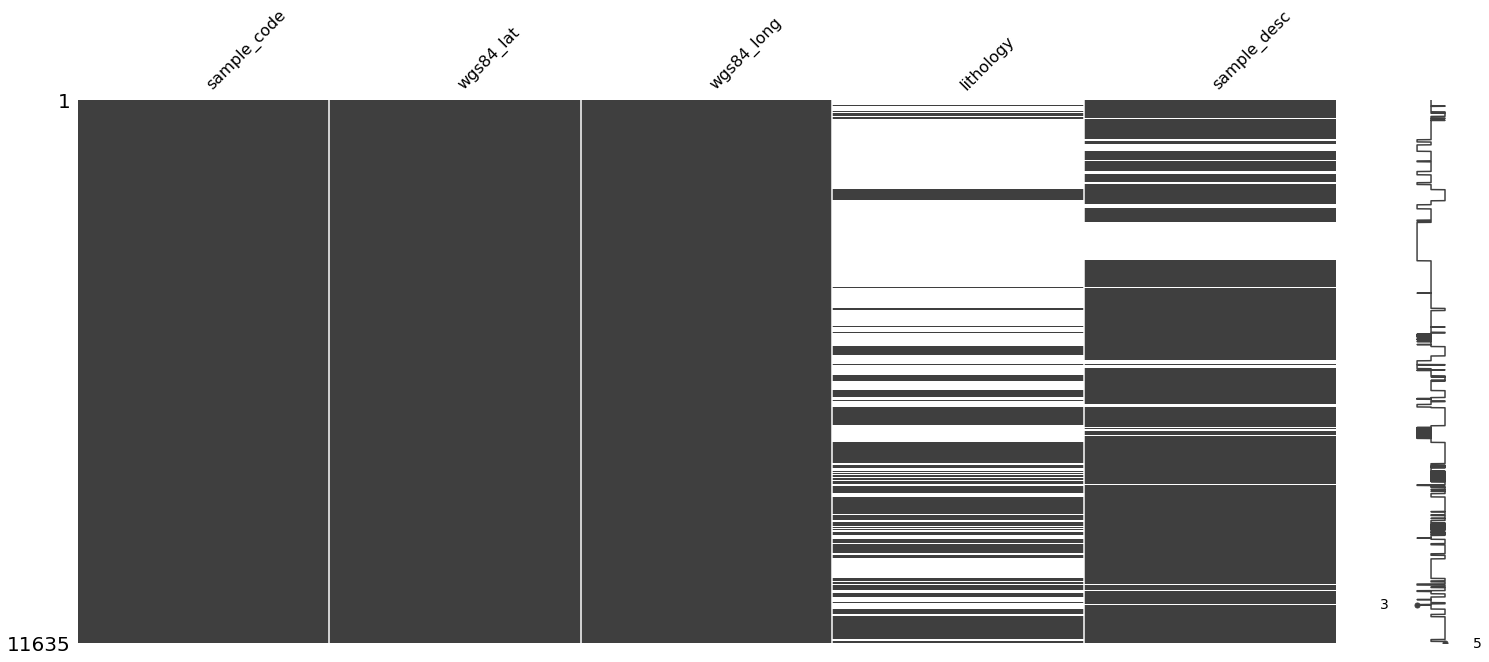

In [10]:
plot = msno.matrix(df)
plot

There doesn't seem to be any specific relationship between these two as far as missing data is concerned. However sample_desc has considerably less missing data.

We then make a target column lith_desc, that contains the lithology and sample_desc. This column will be used for our text data mining. We then take a look at the matrix of missing data again.

In [11]:
df = df.replace(np.nan, '', regex=True)
df['lith_desc'] = df[['lithology', 'sample_desc']].agg(' '.join, axis=1)
df = df.replace(" ",  np.nan)

In [12]:
df = df.drop(['lithology', 'sample_desc'], axis=1) # we no longer need these columns for our purposes.

<AxesSubplot:>

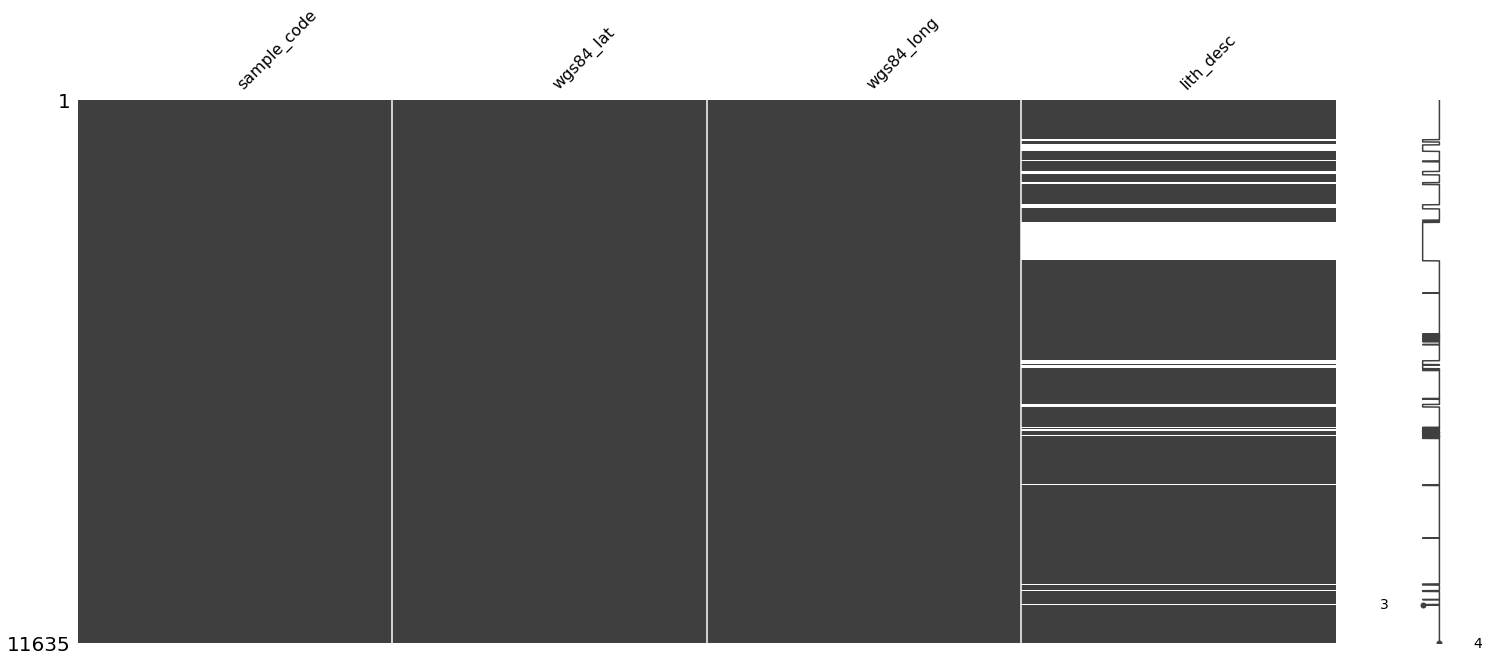

In [13]:
plot = msno.matrix(df)
plot

First thing we'll do is convert everything in the target column into lowercase.

In [14]:
df = df.replace(np.nan, '', regex=True)
df['lith_desc'] = df['lith_desc'].str.lower()

This second step is to add padding to the start and ends of the strings. This will allow us to add spaces in our searches and avoid situations where are search words are parts of other words. For exxample a search replace of ag, for silver, could result in changing aggregate to silvergregate. We can instead search and replace " ag " with " silver ", to avoid this problem.

In [15]:
max_len = df.lith_desc.map(len).max() + 2
df['lith_desc'] = df['lith_desc'].str.pad(max_len, side ='both')

Note, that small words score very low on fuzzy matches with simply 1 letter wrong. For example a 4 letter word with 1 letter wrong would score 75% with a similarity ratio. Looking more carefully at the dataset, or running a spellcheck would help, but alternate correct spellings will also cause problems. In this case some words were manually changed to be consistent.

In [16]:
df = df.replace(' dyke ', ' dike ', regex=True)
df = df.replace(' vien ', ' vein ', regex=True)

We then removed all punctuations. Also note we are replacing punctuations with a space.

In [17]:
df["lith_desc"] = df['lith_desc'].str.replace('[^\w\s]',' ', regex=True)

And we replace abbreviations. This is maintained in the Excel configuration file.

In [18]:
abb_df = pd.read_excel(config_file, sheet_name='abbreviations')

for row in abb_df.itertuples():
    padded_abb = " " + row.abbreviation + " "
    padded_term = " " + row.term + " "
    df['lith_desc'] = df['lith_desc'].str.replace(padded_abb, padded_term, regex=False)

Looking again at our dataset, our target column looks ready for text data mining.

In [19]:
df.head()

,sample_code,wgs84_lat,wgs84_long,lith_desc
0,85GMC-RM001,51.187788,-123.646687,bleached sericitic shear zone quartz veined 3 pyrite cuts andesitic volcanic
1,85GMC-RM002,51.258482,-123.777376,quartz carbonate alteration zone adjacent to felsite intrusive 2 5 pyrite
2,85GMC-RM003,51.196667,-123.666848,carbonate veinlets carrying malachite bornite chalcopyrite cutting andesite
3,85GMC-RM004,51.189498,-123.662452,strongly bleached and pyritic shear zone cutting andesites
4,85GMC-RM005,51.140817,-123.823286,dacite weakly silicifed pyrite and pyrrhotite


## *Text data mining our sets of words*

A list of categorized geological terms are maintained in the Excel configuration file. This file can be altered depending on the purpose for the text mining problem. We use a get_term_list function from above to make this easier. We then create our column names and apply our get_names function to the column.

We'll do this all in a for loop. Note, this code does most of the "heavy lifting", and will take a few minutes to run.

In [20]:
terms_df = pd.read_excel(config_file, sheet_name='terms')

for column in terms_df:
    term_list = get_term_list(terms_df, column)
    df[column] = df.apply(get_names, word_list=term_list, thresh=85, column='lith_desc', axis=1)

We can take a look at the dataset now and see what has happened.

In [21]:
df.head()

,sample_code,wgs84_lat,wgs84_long,lith_desc,alterations,mineralogy,minerals,petrogenesis,rock_names,stratigraphy,strength,structures,text_age,textures
0,85GMC-RM001,51.187788,-123.646687,bleached sericitic shear zone quartz veined 3 pyrite cuts andesitic volcanic,"[bleached, sericitization]","[sericite, quartz, pyrite]",[],[volcanic],"[quartzite, vein, andesite]",[],[],"[shear, vein]",[],[]
1,85GMC-RM002,51.258482,-123.777376,quartz carbonate alteration zone adjacent to felsite intrusive 2 5 pyrite,"[carbonitization, altered]","[quartz, carbonate, pyrite]",[],[],[quartzite],[],[],[intrusion],[],[]
2,85GMC-RM003,51.196667,-123.666848,carbonate veinlets carrying malachite bornite chalcopyrite cutting andesite,[carbonitization],"[carbonate, malachite, bornite, chalcopyrite]",[],[],[andesite],[],[],[veinlets],[],[]
3,85GMC-RM004,51.189498,-123.662452,strongly bleached and pyritic shear zone cutting andesites,[bleached],[pyrite],[],[],[andesite],[],[strongly],[shear],[],[banded]
4,85GMC-RM005,51.140817,-123.823286,dacite weakly silicifed pyrite and pyrrhotite,[silicification],"[pyrite, pyrrhotite]",[],[],[dacite],[],[weakly],[],[],[banded]


## Creating an inference rule to add information to the dataset.

This is just one example of an inference rule that can be used to add information to our dataset. In this case we know that certain rock types have a specific petrogenesis.  We can maintain this data in the Excel configuration file, and run an inference rule with a series of if statements.

In [22]:
petrogenesis_df = pd.read_excel(config_file, sheet_name='petrogenesis')
volcanic_rx = get_term_list(petrogenesis_df, 'volcanic_rx')
plutonic_rx = get_term_list(petrogenesis_df, 'plutonic_rx')
metamorphic_rx = get_term_list(petrogenesis_df, 'metamorphic_rx')
sedimentary_rx = get_term_list(petrogenesis_df, 'sedimentary_rx')
hydrothermal_rx = get_term_list(petrogenesis_df, 'hydrothermal_rx')

for index, row in df.iterrows():
    for rock in row['rock_names']:
        if rock in volcanic_rx and 'volcanic' not in row['petrogenesis']:
            row['petrogenesis'].append('volcanic')
        if rock in plutonic_rx and 'plutonic' not in row['petrogenesis']:
            row['petrogenesis'].append('plutonic')
        if rock in metamorphic_rx and 'metamorphic' not in row['petrogenesis']:
            row['petrogenesis'].append('metamorphic')
        if rock in sedimentary_rx and 'sedimentary' not in row['petrogenesis']:
            row['petrogenesis'].append('sedimentary')
        if rock in hydrothermal_rx and 'hydrothermal' not in row['petrogenesis']:
            row['petrogenesis'].append('hydrothermal')
        

We can see from the first record in our dataset, that "hydrothermal", was a term added to the petrogenesis column due to the presence of "vein" in the lith_desc column. This can be done with any number of domain knowledge applications.

In [23]:
df.head(1)

,sample_code,wgs84_lat,wgs84_long,lith_desc,alterations,mineralogy,minerals,petrogenesis,rock_names,stratigraphy,strength,structures,text_age,textures
0,85GMC-RM001,51.187788,-123.646687,bleached sericitic shear zone quartz veined 3 pyrite cuts andesitic volcanic,"[bleached, sericitization]","[sericite, quartz, pyrite]",[],"[volcanic, hydrothermal]","[quartzite, vein, andesite]",[],[],"[shear, vein]",[],[]


Finally, we then save our dataset as a csv (or alternatively import it directly into a database using a database oriented python library).

In [24]:
df.to_csv('C:/input/geochem_processed.csv')

# *Results*
---

In order to determine the success of our text data mining, we need some way to compare results. We will do this by comparing some search results on the raw data set, and compare them with the text mining process.

In [25]:
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry.point import Point
import geopandas
import matplotlib.pyplot as plt
import matplotlib

In [26]:
config_file = 'C:/input/config.xlsx'
input_file1 = 'C:/input/geochem_processed.csv'
tdm_df = pd.read_csv(input_file1)
input_file2 = 'C:/input/geochem_raw.xlsx'
raw_df = pd.read_excel(input_file2)

## *Utility functions for analyzing results*

In [27]:
def subset_df_on_term(df, term):
    '''
    This function takes any dataframe and subsets that dataframe on a supplied term.
    '''
    mask = np.column_stack([df[col].apply(str).str.contains(term, na=False) for col in df])
    df = df.loc[mask.any(axis=1)]
    return df

We'll use the above function to compare a list of search terms. And print out the resulting dataframe, and plot a barplot of the results.

In [28]:
search_list = ['porphyry', 'sulphides', 'vein', 'breccia', 'mineralization', 'volcanic']
comparison_df = pd.DataFrame(columns=('raw', 'tdm'), index=search_list)
for term in search_list:
    len_raw = len(subset_df_on_term(raw_df, term))
    len_tdm = len(subset_df_on_term(tdm_df, term))
    comparison_df.at[term, "raw"] = len_raw
    comparison_df.at[term, "tdm"] = len_tdm
    
    
comparison_df

,raw,tdm
porphyry,196,280
sulphides,68,92
vein,1048,1251
breccia,252,305
mineralization,97,399
volcanic,445,2044


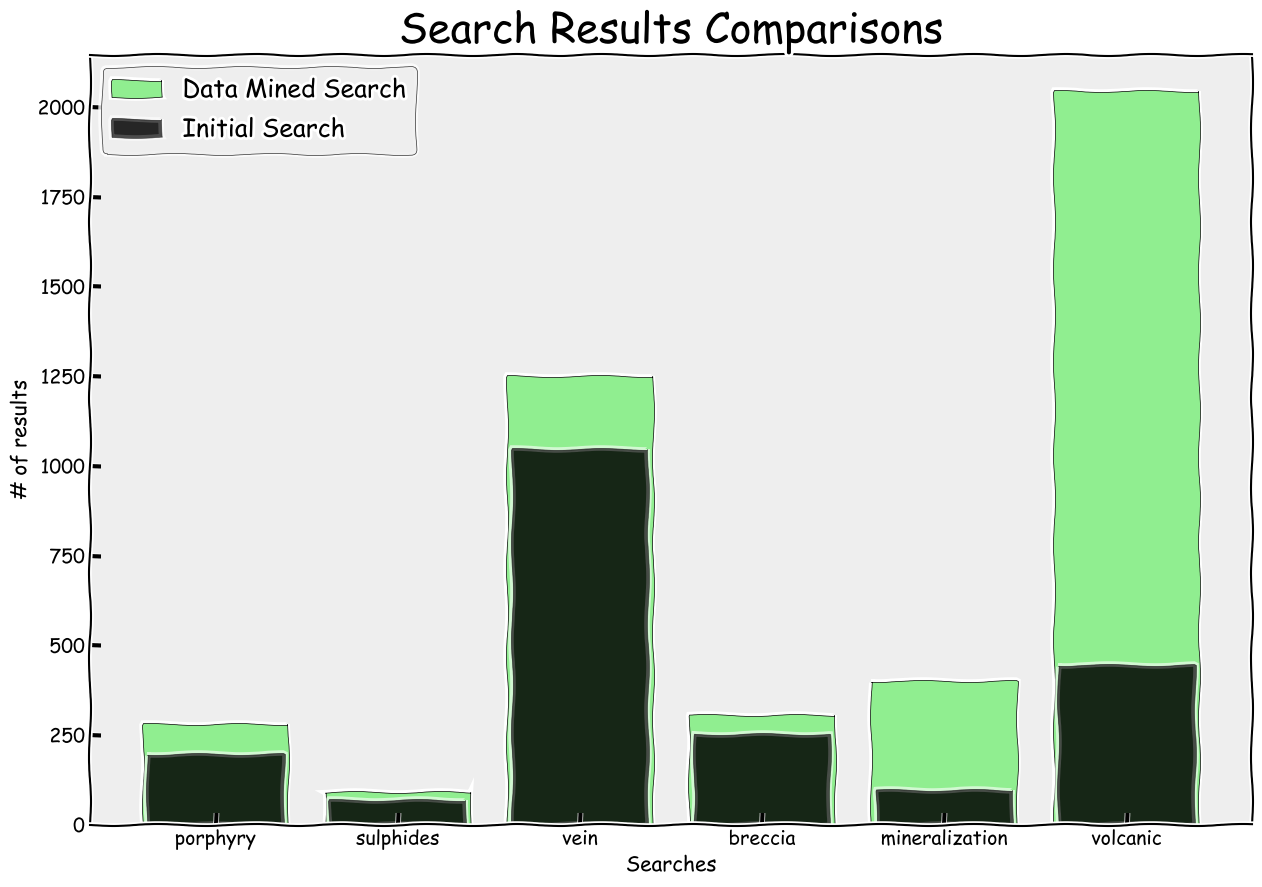

In [117]:
matplotlib.pyplot.xkcd(scale=1, length=100, randomness=2)
plt.figure(figsize=[15, 10])
X = np.arange(len(search_list))
plt.bar(X, comparison_df['tdm'], color='lightgreen', edgecolor='black')
plt.bar(X, comparison_df['raw'], color='black', alpha=0.6, edgecolor='black', width=0.75)
plt.legend(['Data Mined Search', 'Initial Search'], edgecolor='black', fontsize=18)
plt.xticks([i for i in range(6)], search_list)
plt.title("Search Results Comparisons", fontsize=30)
plt.xlabel('Searches', fontsize=15)
plt.ylabel('# of results', fontsize=15)
plt.show()

Note we see a lot more volcanic hits most likely due to the inference rule we created to add information to the dataset,
however all searches show an increase.


## *Spatial View of the TDM Results*

Let's also see a map of these points to see a spatial view of the extra points uncovered through text data mining.
First we'll create a geopandas dataframe for two subsets based on a mineralization search.

In [62]:
search_term = 'volcanic'
crs = 'epsg:26910'

raw_subset_df = subset_df_on_term(raw_df, search_term)
raw_subset_gdf = geopandas.GeoDataFrame(raw_subset_df, 
                                     geometry=geopandas.points_from_xy(raw_subset_df.wgs84_long, raw_subset_df.wgs84_lat),
                                       crs='epsg:4269')
raw_subset_gdf = raw_subset_gdf.to_crs(epsg=26910)
tdm_subset_df = subset_df_on_term(tdm_df, search_term)
tdm_subset_gdf = geopandas.GeoDataFrame(tdm_subset_df, 
                                     geometry=geopandas.points_from_xy(tdm_subset_df.wgs84_long, tdm_subset_df.wgs84_lat),
                                    crs='epsg:4269')
tdm_subset_gdf = tdm_subset_gdf.to_crs(epsg=26910)

In [68]:
print(tdm_subset_gdf.geometry.head(4))

0    POINT (454805.856 5670906.700)
2    POINT (453405.860 5671906.681)
3    POINT (453705.832 5671106.670)
4    POINT (442405.813 5665806.682)
Name: geometry, dtype: geometry


#### We will also bring in a map of the provincial boundaries, and our geophysics outline.

In [63]:
zipfile = "lpr_000b16a_e.zip"
provinces = geopandas.read_file(zipfile)
provinces = provinces.to_crs(epsg=26910)

In [64]:
zipfile = "QUEST_geophysics_outline.zip"
geophysics = geopandas.read_file(zipfile)
geophysics = geophysics.to_crs(crs=26910)

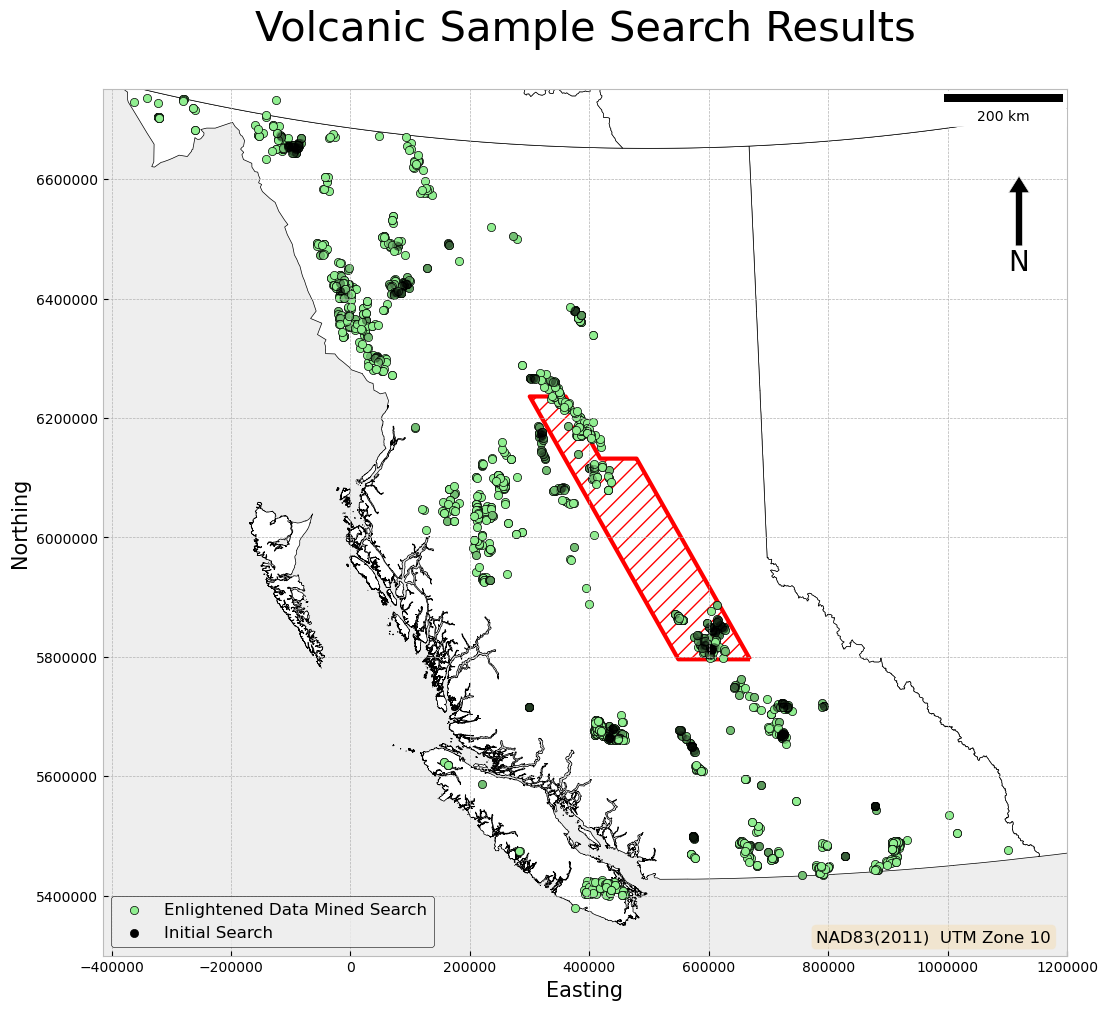

In [93]:
matplotlib.style.use('bmh')
fig, ax1 = plt.subplots(1,1,sharex=True,sharey=True,figsize=(20,10))
tdm_num = len(tdm_subset_gdf)
raw_num = len(raw_subset_gdf)
plt.xlim([-415000, 1200000])
plt.ylim([5300000, 6750000])
ax1.get_xaxis().get_major_formatter().set_scientific(False)
ax1.get_yaxis().get_major_formatter().set_scientific(False)
ax1.margins(x=0, y=0)
ax1.add_artist(ScaleBar(dx=1, units="m",))
provinces.plot(ax=ax1, color='w', edgecolor='black')
geophysics.plot(ax=ax1, color='w', edgecolor='red', linewidth=3.0, facecolor="pink", hatch="//")
tdm_subset_gdf.plot(ax=ax1, markersize=35, edgecolors="black", c="lightgreen", label=str(tdm_num) + "Search Using Text Data Mining")
raw_subset_gdf.plot(ax=ax1, markersize=35, edgecolors="black", c='black', alpha=0.2, label=str(raw_num) +"Search on Raw Data")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = 'NAD83(2011)  UTM Zone 10'
ax1.text(0.74, 0.03, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
fig.tight_layout()
plt.xlabel('Easting', fontsize=15)
plt.ylabel('Northing', fontsize=15)
x, y, arrow_length = 0.95, 0.9, 0.1
ax1.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax1.transAxes)
legend = plt.legend(['Enlightened Data Mined Search', 'Initial Search'], edgecolor='black', loc='lower left', fontsize=12)
for lh in legend.legendHandles: 
    lh.set_alpha(1)
title = search_term.capitalize() + " Sample Search Results"
fig.suptitle(title, fontsize=30)
fig.subplots_adjust(top=0.90)